# USA GDP Projections

The purpose of my work in this document is to project GDP value by industry for the United States of America. The GDP value is calculated as the GDP contribution minus the value of the intermediate resources consumed by the industries. The values present in this dataset represent the proportion of the total national GDP contributed by the specific industries. I will explore the data, identify trends, and train deep learning models to predict GDP contributions by certain industries through 2030.

Data was retrieved from the Bureau of Economic Analysis [here](https://www.bea.gov/itable/gdp-by-industry).

Over the course of this notebook, I will cover:
- Exploratory data analysis (EDA)
- Data preprocessing
- Model architecture
- Hyperparameter tuning
- Results and analysis
- Conclusion

In [3]:
#imports
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras import layers
from sklearn.metrics import mean_squared_error

import helper as h

## EDA

The data contains the proportion of GDP value contributed by all categories of the US economy. Some examples of categories are agriculture and finance. It has information from years 1947-2023. Initially, each row was a category and each column was a year. I performed a number of data preparation steps:
- Focus on a subset of columns
- Rename columns to have shorter names
- Join historical data (1947-1997) with recent data (1997-present)
- Transpose the dataframe so each row is a year and each column is a category
- Replace null values ('...') and cast categories as proper datatypes  

After performing these steps, the resulting dataframe is 77 x 20. Each row is a year and each column is a category for the US economy.

In [4]:
#call pipeline function
df = h.eda_pipeline()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 1947 to 2023
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Private industries              77 non-null     float64
 1   Government                      77 non-null     float64
 2   Agriculture                     77 non-null     float64
 3   Mining                          77 non-null     float64
 4   Utilities                       77 non-null     float64
 5   Construction                    77 non-null     float64
 6   Manufacturing                   77 non-null     float64
 7   Wholesale trade                 77 non-null     float64
 8   Retail trade                    77 non-null     float64
 9   Transportation and warehousing  77 non-null     float64
 10  Information                     77 non-null     float64
 11  Data services                   77 non-null     float64
 12  Finance and insurance           77 non

I have some questions I would like to answer by exploring my data. The questions I will seek to answer are:
- How much do the private sector and government contribute to GDP value?
- Which industries have grown the most since data was collected?
- When did certain industries begin growing rapidly?
- Which industries have diminished the most since data was collected?
- When did certain industries start declining?

### Government and private sector contribution
How much do each contribute to the national GDP?

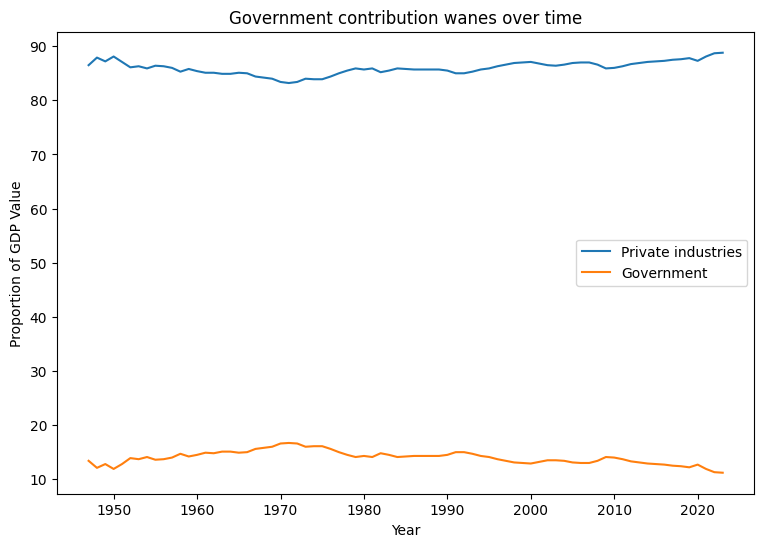

In [5]:
#plot function from helper document
h.lineplot(df, ['Private industries', 'Government'], 'Government contribution wanes over time')

In [6]:
#view most recent values
df.tail(1)[['Private industries', 'Government']]

,Private industries,Government
2023,88.8,11.2


As you can see, the private sector contributes greatly to GDP value. There were a few decades from 1960-1990 where government contribution is elevated. In recent decades, government contribution has declined to its current value of 11.2.

### Industry growth

Which industries have grown the most since 1947?

In [7]:
#normalizing the differences by each category's max value
change_over_time = (df.iloc[-1] - df.iloc[0]) / df.max()
change_over_time.sort_values(ascending=False).head()

Data services            1.000000
Health care              0.776316
Professional services    0.746154
Educational services     0.615385
Finance and insurance    0.612500
dtype: float64

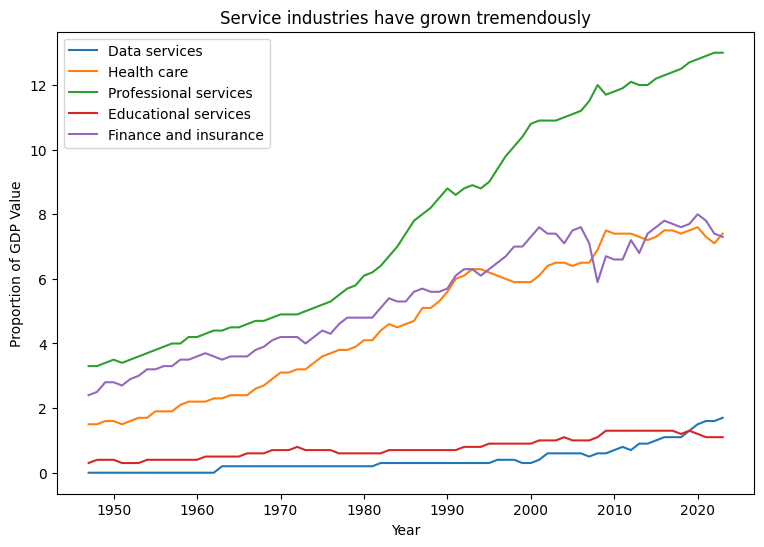

In [8]:
#line plot of relevant categories
h.lineplot(df, ['Data services', 'Health care', 'Professional services',
                'Educational services', 'Finance and insurance'],
                'Service industries have grown tremendously')

Data services saw total growth because the industry didn't exist (or wasn't recorded) until the 1960s. As you can see, data services have grown greatly since we began to computerize everything. It's a good sign for us! Other sectors that have grown significantly are health care, professional services (legal, consulting, management, and administrative), educational services, and finance and insurance.

### When did these industries grow rapidly?

A few of the categories show steady growth over time: finance and insurance, health care, and educational services. There are a few points worth mentioning: the historic stock market crash of 2008 is reflected in the nosedive of the finance and insurance sector. Around the same time, the uptick in health care may be because of Obamacare. There is another uptick in health care in the 1990s which may be due to policies enacted by the Bill Clinton administration.

A couple categories begin to climb in GDP contribution at specific points in time. Professional services has grown greatly since 1980 and data services have climbed since 2000. The growth of data services certainly reflects the widespread adoption of computers.

### Industry loss

Which industries have shrunk the most since 1947?

In [9]:
#sort the other way (smallest values at top)
change_over_time.sort_values().head()

Agriculture                      -0.833333
Federal                          -0.608696
Manufacturing                    -0.540925
Transportation and warehousing   -0.403509
Retail trade                     -0.311828
dtype: float64

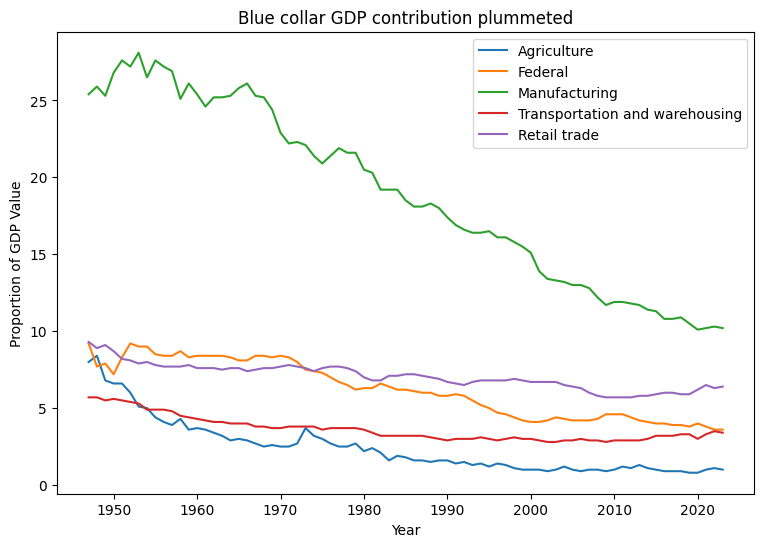

In [10]:
#create line plot
h.lineplot(df, ['Agriculture', 'Federal', 'Manufacturing', 'Transportation and warehousing',
                'Retail trade'], 'Blue collar GDP contribution plummeted')

Blue collar sectors of the US economy contribute far less to the GDP today than they did in decades prior. The most obvious decline is seen in manufacturing. The US has increasingly outsourced production to other countries where the labor is cheaper. Manufacturing used to contribute over one QUARTER of the United States' entire GDP. Interestingly, even though they have declined overall, there are some slight upticks to retail trade and transportation and warehousing in recent years.

### When did these industries decline?

A few of the industries display similar behavior: retail trade, agriculture, and transportation and warehousing. They experienced a decline from 1947 through about the year 2000, after which they have leveled off or even grown slightly. Federal and manufacturing also display similar behavior: They grew abruptly around 1950 and have been in steady decline since. The spike in manufactoring can be [attributed](https://progressless.org/2023/09/08/is-u-s-manufacturing-showing-signs-of-growth/) to the strong economy after WWII and the booming automotive industry.

## Data preprocessing

To train my models to learn from the data, I need to slice my data up into X and y. My X values will be 10 consecutive values from my dataset. The y value corresponding to each X will be the 11th value. Using the units from my dataset, I will be feeding the past decade's information to predict next year's value. Using this method, I can create enough training examples from my dataset to construct decent models. The workflow (found in my helper python file):
- Provision empty arrays
- Convert column of interest to numpy array
- Iterate through and generate slices of dataset
- Return full arrays

It's important to return the full arrays because I can segment them for model training and tuning. At the end, I can fit my models to the entire dataset and predict the values out through 2030. Note: because of the way my model works, I will have to use some predictions to make future ones. This is a possible source of error later on.

I will use the health care column to train and tune my models. I chose this feature because it steadily increases over time with some noise. I think it will be a good test for my models.

In [11]:
#create training sets for health care category
X_hc, y_hc = h.preprocess(df, 'Health care')
X_hc.shape, y_hc.shape

((66, 10), (66,))

### Baseline

I should also define a baseline for my machine learning project. My baseline will be the last value in the X set. I'm choosing this as the baseline because my data tends to display simple trends: it either continues to go up or down over time. I think the last value from each set will give a good estimation. As you can see from the cell below, my baseline will be a mean squared error (MSE) of 0.03. That is really low! It will be difficult to beat with machine learning.

In [12]:
#make pred based on last value in y
round(mean_squared_error(y_hc, X_hc[:,9]), 3)

0.03

## Model architecture

There are a number of options for deep learning architecture for time series data, including basic RNN, LSTM, and GRU. These architectures are appropriate because they process sequential data. They allow past values to influence how they process current values and predict future ones. Since my problem appears to be a simple one, I will begin with a basic RNN model. I will compare its performance to LSTM and GRU on the health care feature. I will determine the best model architecture for my problem and move on to hyperparameter tuning. I decided to start with a small and basic model. I don't have many nodes in my network because my input is only 10 values for X!

In [13]:
#define shape of inputs
shape = (66,1)
#define basic model
rnn = keras.Sequential([
    layers.Input(shape=shape),
    layers.SimpleRNN(16, activation='leaky_relu'),
    layers.Dense(8, activation='leaky_relu'),
    layers.Dense(1),
])

rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 16)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#create custom callback to stop training when val mse no longer improves
callback = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=3, verbose=1, restore_best_weights=True)
#compile focused on mse
rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
#fit to dataset with no verbosity (cleaner notebook)
rnn_hist = rnn.fit(X_hc, y_hc, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 50.


What does it look like when we train the model? Let's have a look.

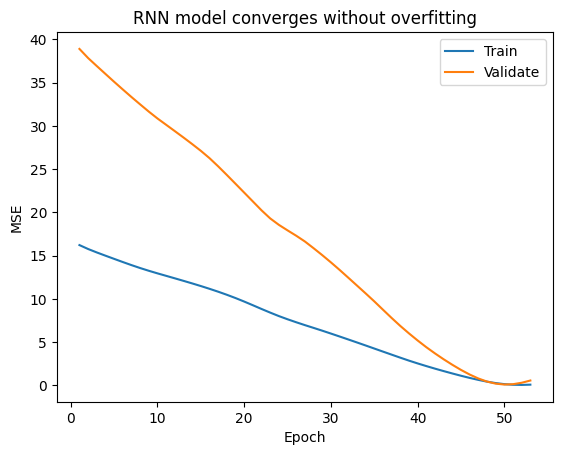

In [16]:
#plot mse over time from model fitting
plt.plot(range(1,54), rnn_hist.history['mean_squared_error'], label='Train')
plt.plot(range(1,54), rnn_hist.history['val_mean_squared_error'], label='Validate')
plt.title('RNN model converges without overfitting')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [19]:
#define lstm model
lstm = keras.Sequential([
    layers.Input(shape=shape),
    layers.LSTM(16, activation='leaky_relu'),
    layers.Dense(8, activation='leaky_relu'),
    layers.Dense(1),
])
#perform similar work to above to fit model
callback = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=3, verbose=1, restore_best_weights=True)
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
lstm_hist = lstm.fit(X_hc, y_hc, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 52.


In [18]:
#define gru model
gru = keras.Sequential([
    layers.Input(shape=shape),
    layers.GRU(16, activation='leaky_relu'),
    layers.Dense(8, activation='leaky_relu'),
    layers.Dense(1),
])
#same workflow
callback = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=3, verbose=1, restore_best_weights=True)
gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
gru_hist = gru.fit(X_hc, y_hc, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 62.


Now that I have created and trained simple models using different types of recurrent neural networks, I will compare them to see if there is an obvious winner.

In [21]:
#create dataframe of results
model_sel = pd.DataFrame({'Model': ['RNN', 'RNN', 'LSTM', 'LSTM', 'GRU', 'GRU'],
                          'Subset': ['Train', 'Validate', 'Train', 'Validate', 'Train', 'Validate'],
                          'MSE': [rnn_hist.history['mean_squared_error'][49], rnn_hist.history['val_mean_squared_error'][49],
                                  lstm_hist.history['mean_squared_error'][53], lstm_hist.history['val_mean_squared_error'][53],
                                  gru_hist.history['mean_squared_error'][61], gru_hist.history['val_mean_squared_error'][61]]})
model_sel

,Model,Subset,MSE
0,RNN,Train,0.139664
1,RNN,Validate,0.094360
2,LSTM,Train,0.557018
3,LSTM,Validate,4.816763
4,GRU,Train,0.047845
5,GRU,Validate,0.066694


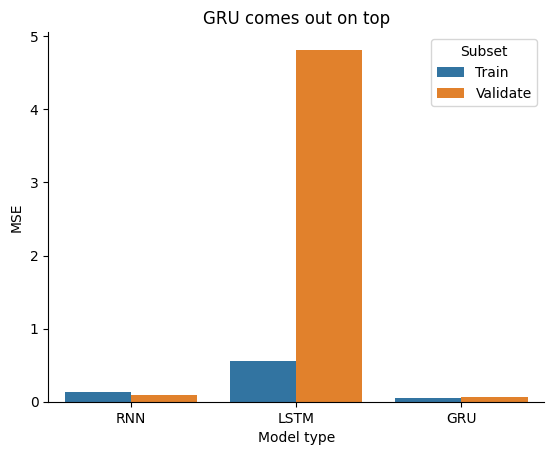

In [22]:
#use dataframe to plot
sns.barplot(model_sel, x='Model', y='MSE', hue='Subset')
plt.xlabel('Model type')
plt.title('GRU comes out on top')
sns.despine()

As I can see from the table and plot, the GRU is clearly better than the other models. In the case of the LSTM model, it shows some strange behavior. It appears to have a better fit to the validation data than the train data. I think the LSTM may suffer from being a more complex model in this application: we may not need a ton of parameters to learn from 10 datapoints! The GRU may be best because it's the middle ground: it's more complex than the basic RNN and has fewer parameters than the LSTM. I will perform all future experiments with the GRU as my base architecture. It does, however, fail to beat the initial baseline of 0.3. I'm hopeful hyperparameter tuning will enable me to beat my baseline. I will attempt to tune a number of hyperparameters:
- Number of layers
- Size of layers

In [23]:
#define deeper model with another dense layer
gru_dd = keras.Sequential([
    layers.Input(shape=shape),
    layers.GRU(16, activation='leaky_relu'),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dense(8, activation='leaky_relu'),
    layers.Dense(1),
])
#train
callback = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=3, verbose=1, restore_best_weights=True)
gru_dd.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
gru_dd_hist = gru_dd.fit(X_hc, y_hc, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 70.


In [24]:
#define deeper model with another RNN layer
gru_dr = keras.Sequential([
    layers.Input(shape=shape),
    layers.GRU(32, activation='leaky_relu', return_sequences=True),
    layers.GRU(16, activation='leaky_relu'),
    layers.Dense(8, activation='leaky_relu'),
    layers.Dense(1),
])
#train
callback = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=3, verbose=1, restore_best_weights=True)
gru_dr.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
gru_dr_hist = gru_dr.fit(X_hc, y_hc, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 35.


In [26]:
#create dataframe of results
model_depth = pd.DataFrame({'Layers': ['Normal', 'Normal', 'Two Dense', 'Two Dense', 'Two GRU', 'Two GRU'],
                          'Subset': ['Train', 'Validate', 'Train', 'Validate', 'Train', 'Validate'],
                          'MSE': [gru_hist.history['mean_squared_error'][61], gru_hist.history['val_mean_squared_error'][61],
                                  gru_dd_hist.history['mean_squared_error'][69], gru_dd_hist.history['val_mean_squared_error'][69],
                                  gru_dr_hist.history['mean_squared_error'][34], gru_dr_hist.history['val_mean_squared_error'][34]]})
model_depth

,Layers,Subset,MSE
0,Normal,Train,0.047845
1,Normal,Validate,0.066694
2,Two Dense,Train,0.043356
3,Two Dense,Validate,0.067802
4,Two GRU,Train,0.376552
5,Two GRU,Validate,0.124572


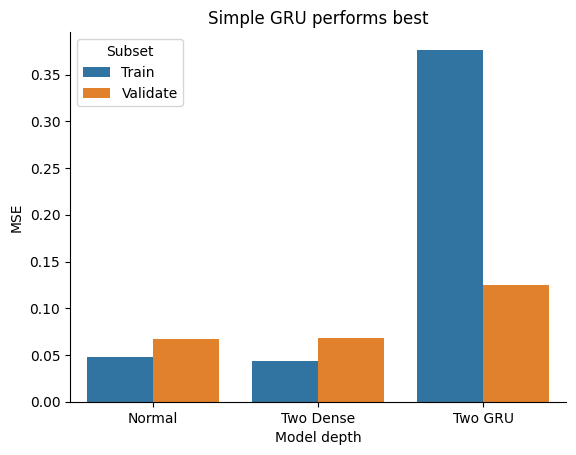

In [27]:
#use dataframe to plot
sns.barplot(model_depth, x='Layers', y='MSE', hue='Subset')
plt.xlabel('Model depth')
plt.title('Simple GRU performs best')
sns.despine()

A couple interesting things here. First, one of the deeper models performed substantially better on validate than they did on train. I think this is because there is higher variance in model performance due to the larger number of trainable parameters. Second, the model with two dense layers converged later than the other two at 70 epochs. The model with two GRU layers much sooner after 35 epochs and had poor results. The two dense model was comparable to the model with one dense layer. Since it is less complex and has better performance, I'm sticking with the simple model: one GRU layer, one dense layer, one output node.

I want to see how smoothly one of these deeper models converges on its final weights.

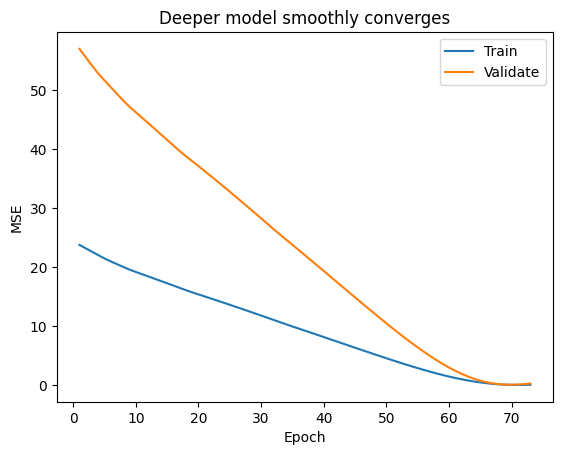

In [28]:
#plot mse of deeper model during training
plt.plot(range(1,74), gru_dd_hist.history['mean_squared_error'], label='Train')
plt.plot(range(1,74), gru_dd_hist.history['val_mean_squared_error'], label='Validate')
plt.title('Deeper model smoothly converges')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

I didn't necessarily expect this result. It's still smooth descent to model convergence. The final MSE is a bit higher (worse) than my shallower model. Something else I find interesting about this chart is that further training looks like it would not be beneficial! The validate MSE clearly goes higher in the last couple epochs. Even though these deeper models smoothly converged, they had final results inferior to my simple model. The way these models converge is quite different to the convolutional models I used earlier in the course.

Now that I am ok with the short list of layers in my model, I will try having some broader (more nodes) layers in my neural network. Given this recent experiment, I'm not sure what to expect.

In [29]:
#define model with broader layers
gru_big = keras.Sequential([
    layers.Input(shape=shape),
    layers.GRU(32, activation='leaky_relu'),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dense(1),
])

#train
callback = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=3, verbose=1, restore_best_weights=True)
gru_big.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
gru_big_hist = gru_big.fit(X_hc, y_hc, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 33.


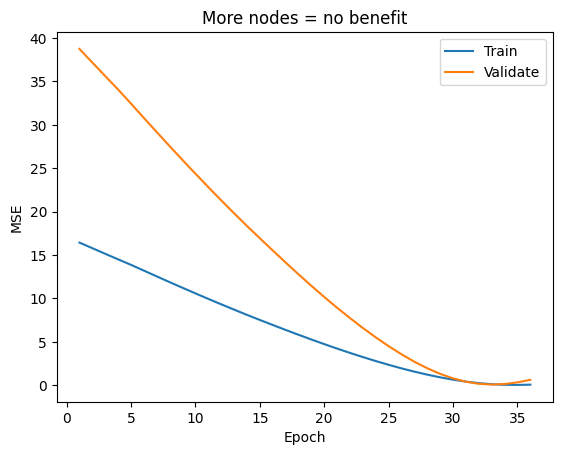

Best MSE: 0.086.


In [31]:
#plot mse of deeper model during training
plt.plot(range(1,37), gru_big_hist.history['mean_squared_error'], label='Train')
plt.plot(range(1,37), gru_big_hist.history['val_mean_squared_error'], label='Validate')
plt.title('More nodes = no benefit')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

print(f"Best MSE: {round(min(gru_big_hist.history['val_mean_squared_error']), 3)}.")

This model converged a bit quicker: 36 epochs, compared to 62 for the original model. It appears that increasing model complexity, whether with more layers or larger layers, doesn't help the model predict the outcome. As a result, I ended up with my original hyperparameters for the GRU model.

When I added additional layers...
- Train MSE was worse than validate MSE
- MSE was worse (bigger)

When I made the layers larger...
- The model converged a bit quicker
- It showed signs of overfitting after that
- Performance worse than simpler model

For these reasons, I will stick with my simple model that has input, GRU, dense, and output node. Now, for the grand finale. I will train the same model architecture on each feature in my dataset. I will compute the baseline and its MSE for each feature, I will compute the overall MSE for my feature across the entire dataset, and I will generate predictions through 2030. It sounds like a lot, but the process is broken down in my helper script.

Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 50.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


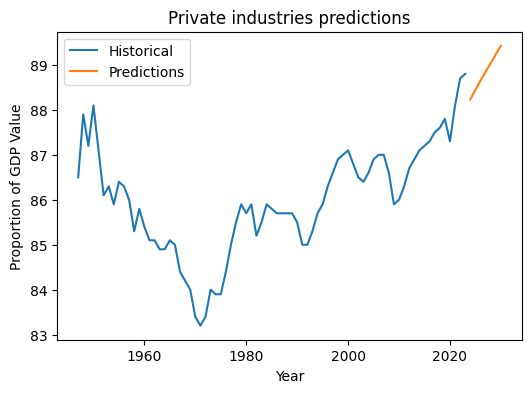

Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 70.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


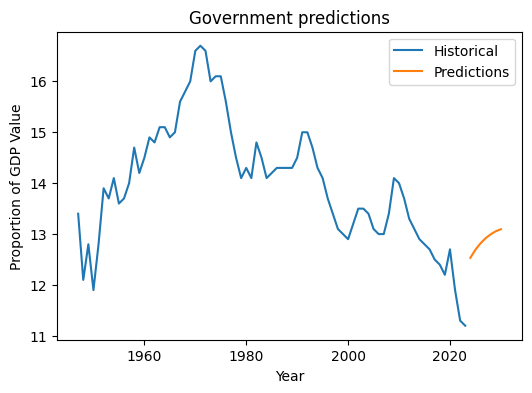

Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 55.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


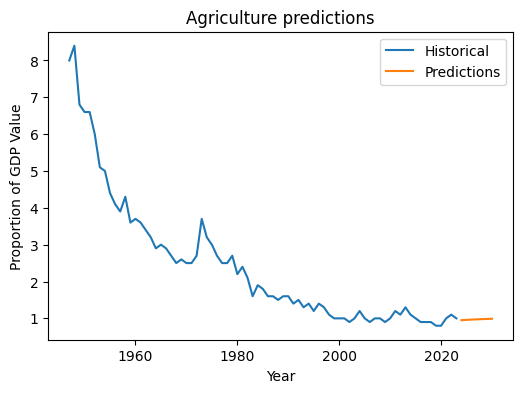

Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 41.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


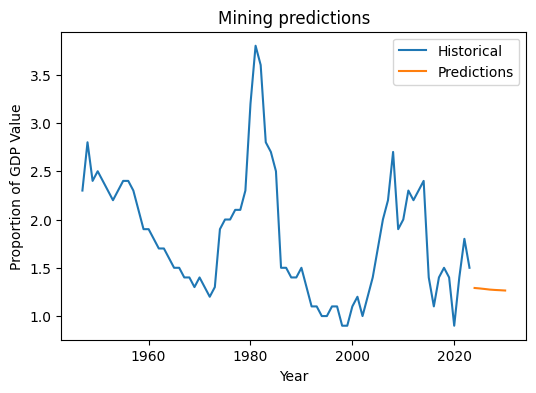

Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 55.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


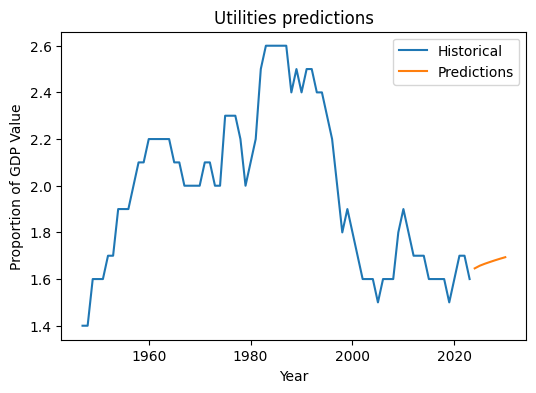

Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 92.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


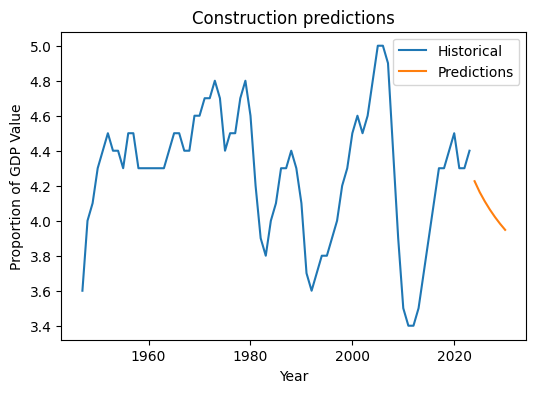

Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 54.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


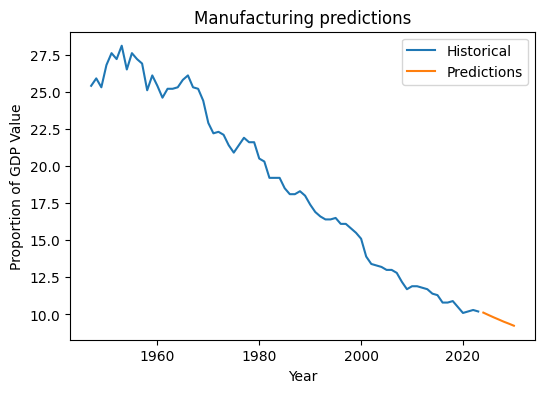

Epoch 75: early stopping
Restoring model weights from the end of the best epoch: 72.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


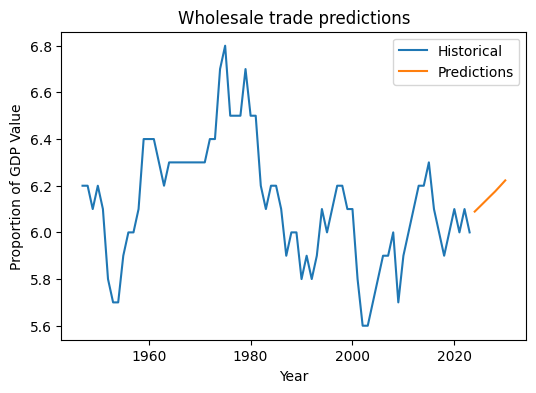

Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 46.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


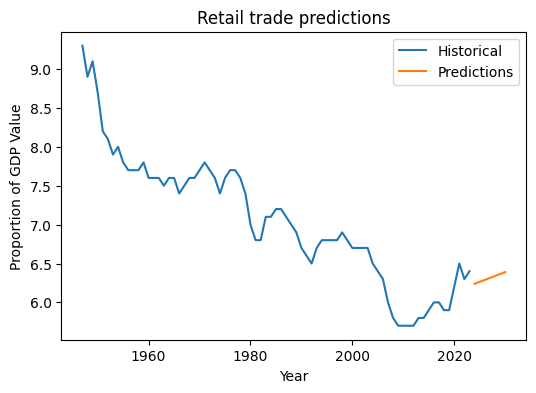

Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 61.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


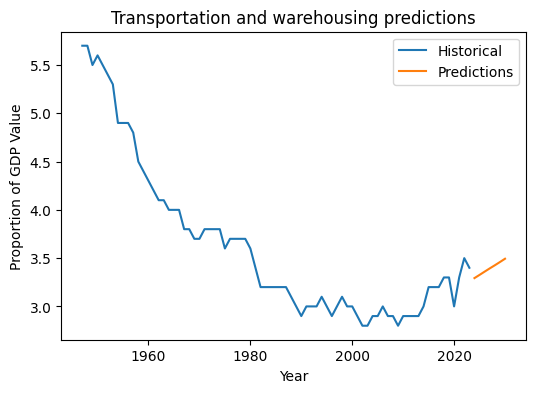

Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 95.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


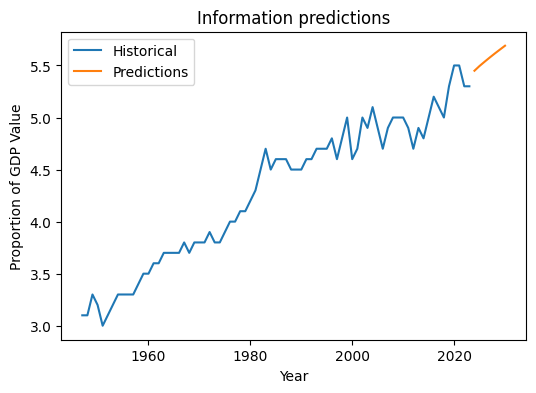

Restoring model weights from the end of the best epoch: 100.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


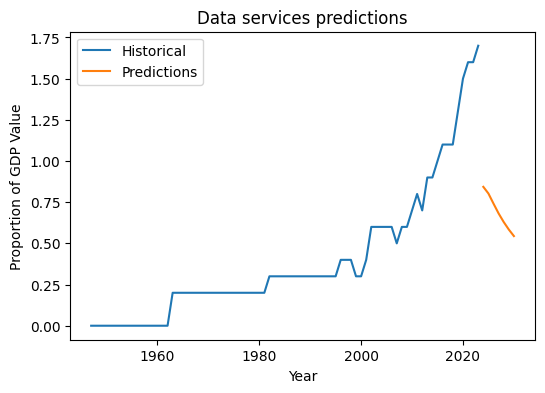

Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 86.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


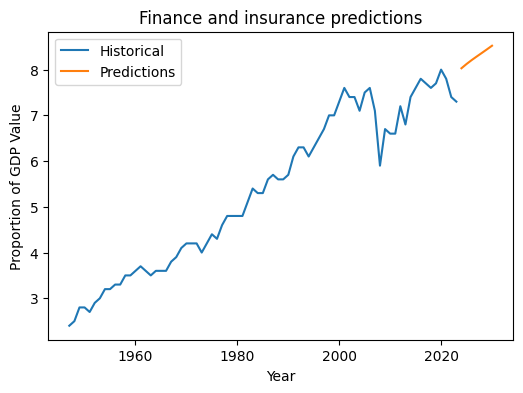

Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 65.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


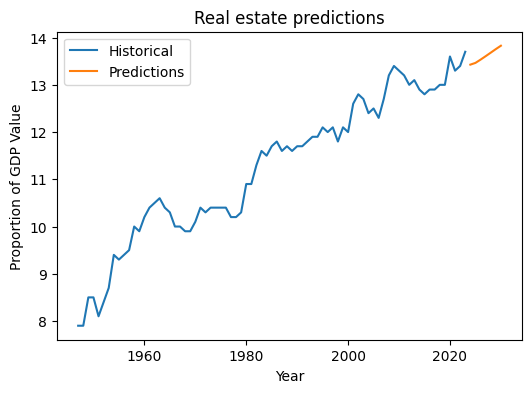

Restoring model weights from the end of the best epoch: 100.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


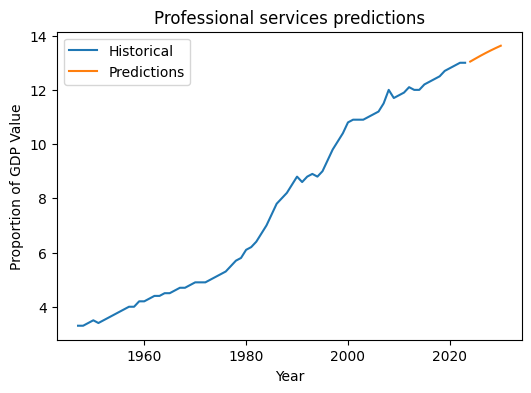

Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 32.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


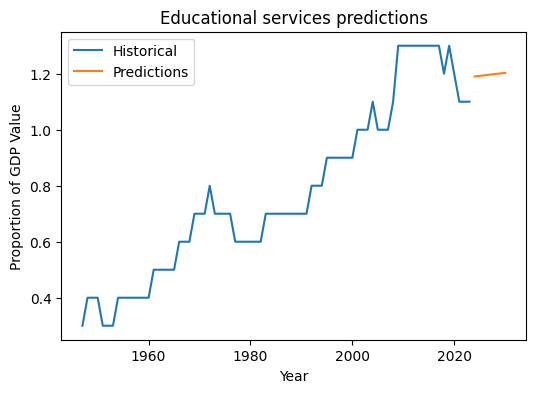

Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 63.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


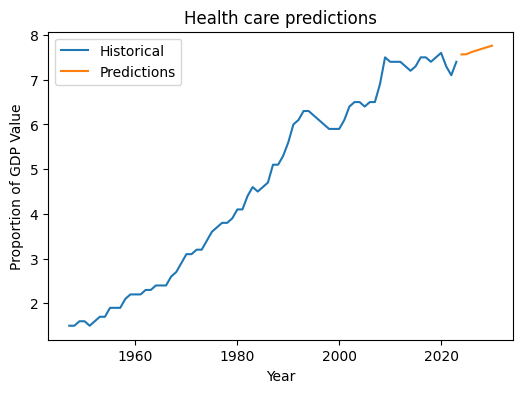

Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 60.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


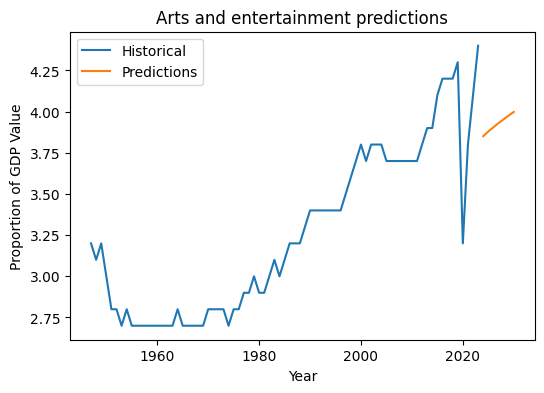

Epoch 96: early stopping
Restoring model weights from the end of the best epoch: 93.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


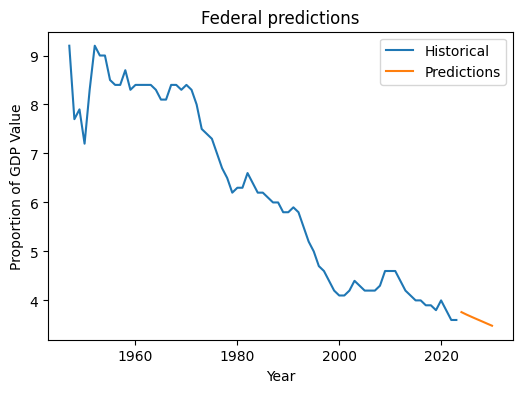

Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 63.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


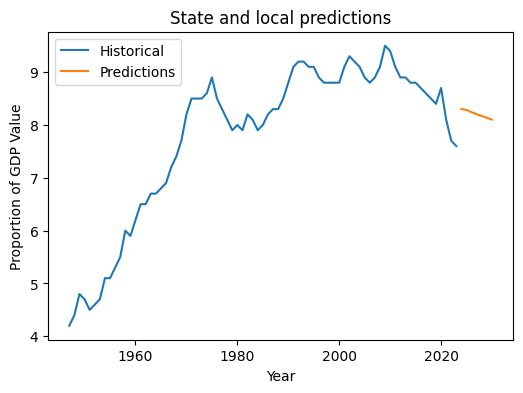

,Feature,Baseline,Train MSE,Validate MSE
0,Private industries,0.1197,0.247406,0.221394
1,Government,0.1191,2.107301,0.293943
2,Agriculture,0.0588,0.287697,0.020442
3,Mining,0.1052,0.185357,0.141450
4,Utilities,0.0103,0.036552,0.011766
5,Construction,0.0312,0.078362,0.121487
6,Manufacturing,0.2914,4.553721,0.090990
7,Wholesale trade,0.0177,0.030671,0.021817
8,Retail trade,0.0188,0.037991,0.054852
9,Transportation and warehousing,0.0121,0.093548,0.019187


In [1]:
#call super function
results = h.gen_preds(df)
results

## Results and analysis

As you can see, the quality of the predictions varies quite a bit. Some of them smoothly continue the trend present in the data, such as the federal, health care, and professional services predictions. Others look a bit more like the data services predictions.

The GRU model is able to retain information learned from earlier data points. This worked well for categories with consistent trends and seasonality over time. Even though some of the projections may look a bit funny (smooth orange line as opposed to choppy blue line), I think they represent the trends in the data well. The only time the model truly falls flat is with data services. In this case, the values were 0 (or close to it) for the first few decades of information. There is only a spike in contribution to GDP value after the widespread adoption of computers and the invention of the internet. Since the model learned from the past decades of slim to no value, it predicted a return toward these values over time. I think it's clear that data services will continue to expand on into the future. In this case, the GRU model's ability to retain past information worked against it.

I had to troubleshoot one main problem with my modeling section: the RNN results are deceptively bad. The RNN model scores surprisingly low on the train and validate MSE. When I looked at its predictions over the entire dataset, I noticed something was wrong. I calculated the MSE for the entire dataset and got 16! I determined the model must be simply guessing the last value (or something like that) during the training cycle. When asked to predict over the entire dataset, it misses the mark by a wide margin. I discovered this problem by printing the predictions and analyzing them. It became clear I should use the GRU model.

I attempted to optimize a few hyperparameters in this notebook. I started with what I thought were the biggest changes and moved to the smallest ones. I tried a few different recursive neural network architectures: simple RNN, LSTM, and GRU. I settled on GRU before trying different depths of the model by adding a GRU or dense layer. I found the simple architecture to be the best: input, GRU, dense, output. Once I thought I had a model of appropriate depth, I tried making the layers larger. Adding more parameters did lead to faster convergence, but model performance on the out-of-sample validate set was worse. Happy with my model architecture and other hyperparameters, I created a model for each category and generated predictions.

## Conclusion

In conclusion, I built a number of machine learning models that projected GDP value generated by sectors of the US economy through 2030. I determined the optimal model architecture and hyperparameters using data I thought was representative of my entire dataset. I used the health care category because it displayed a trend over time with some noise. I settled on a simple GRU model with an input layer, GRU layer, dense layer, and output layer. I trained a unique model for each category in my dataset and used it to project GDP value through 2030. I programmatically plotted the results and verified that most projections look reasonable.

The one unreasonable result was for data services (ironic). The GRU model performed poorly because the category has many 0's (or close to it) for decades. The GRU model predicted a downturn toward the historical values. In this case, the past knowledge of the GRU model was detrimental to the quality of the predictions. A simpler model based only on the recent data point would have performed better. Speaking of simplicity: I learned that simpler models can be preferable to complex ones. The simplest model architecture performed the best on my dataset. I recognize my dataset was a bit simplistic, so the result makes sense. I also learned that creating many models to solve a problem calls for a more nuanced approach. Instead of selecting the GRU model based on its performance on one category and applying it to my entire dataset, I should choose and optimize specific models for each feature. This would be more time consuming, but with a little programming magic, could be automated and would lead to better results.

To improve my project in the future, I would create customized models for each category. I would also look for data sources with more granular data: I know some of these values are calculated on a quarterly basis. More data points may lead to better models and more accurate predictions. Finally, I would look for other potential factors that may influence the GDP value contributed by the different categories. Would it be possible to encode that information in a way a model can use? I'm not sure, but I would like to try.